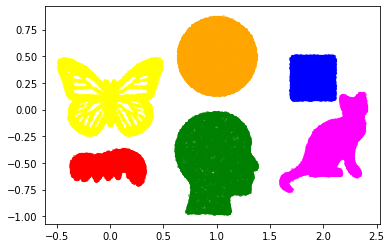

In [11]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel, matplotlib
import ot
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory

im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')

In [101]:
import Utils; importlib.reload(Utils); from Utils import SaveTrajectory as st
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));
model = FfjordModel(sigmac = 3.5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
model.load_state("results/experiment_radial/models/state_final.tar")
x_trajs = st.save_trajectory(model, keyframes, savename='save_debug', nsteps=10, dpiv=400, n=100, alpha=1, ot_type=1, writeTracers=True)


In [104]:

BB = BoundingBox(x_trajs.permute(2,0,1))
emic,emac = BB.extendedBB(1.1)
ax.set_xlim(emic[0], emac[1])
ax.set_ylim(emic[1], emac[1])

tensor([-0.9713, -0.8397], grad_fn=<AddBackward0>)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 432x288 with 0 Axes>

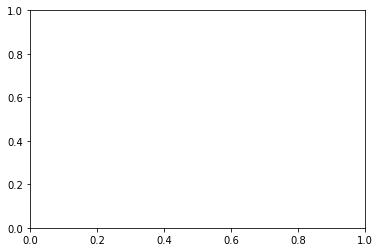

In [108]:
savedir = 'results/outcache/'
savename = '0'
dpiv = 400
fig = plt.figure()
alpha = 1
nsteps=20
subsample_inds = torch.randperm(keyframes.shape[1])[:1000]
z_target = keyframes[:, subsample_inds, :]
BB = BoundingBox(z_target)
z_sample = BB.sampleuniform(t_N=1, x_N=20, y_N=20)
z_sample_d = z_sample.cpu().detach().numpy()
T = z_target.shape[0]
integration_times = torch.linspace(0, T-1, nsteps).to(device)
cpt = time.time()

n = x_trajs.shape[0]
d = x_trajs.shape[1]
nf = x_trajs.shape[2]
nft = torch.linspace(0,1,nf)
cs = torch.tensor((.5, .6, 1))
cf = torch.tensor((.2, 1, .2))
x_trajs_f = x_trajs.transpose(1,2)
nanc = torch.zeros(n,1,d)*float("nan")
moviewriter = matplotlib.animation.writers['ffmpeg'](fps=15)
# fig, (ax) = plt.subplots(1,1)
# BB = BoundingBox(x_trajs.permute(2,0,1))
# emic,emac = BB.extendedBB(1.1)
# ax.set_xlim(emic[0], emac[1])
# ax.set_ylim(emic[1], emac[1])
with moviewriter.saving(fig, savedir + 'traj_'+savename+'.mp4', dpiv):
    for tt in range(T):
        plt.scatter(
            z_target.cpu().detach().numpy()[tt, :, 0],
            z_target.cpu().detach().numpy()[tt, :, 1],
            s=10, alpha=alpha, linewidths=0, c='blue', zorder = 2)

    for t in range(0,nf):
        if t>0:
            # plot tracers
            ctt = (cs*(1-nft[t])+cf*nft[t])
            ct = (ctt[0].item(),ctt[1].item(),ctt[2].item())
            segment_t = x_trajs_f[:,t-1:t+1,:]
            testp = torch.cat((segment_t, nanc),dim=1).reshape(-1,d).detach().cpu().numpy()
            plt.plot(testp[:,0],testp[:,1],alpha=.3, lw=.5, color = ct, zorder = 1)
        
        # plot endpoints
        endpoints = x_trajs[:,:,t].detach().cpu().numpy()
        scr = plt.scatter(endpoints[:, 0], endpoints[:, 1], s=10,
                    alpha=1, linewidths=0, color="g", zorder = 2)

        plt.axis('equal')
        moviewriter.grab_frame()
        scr.remove()
moviewriter.finish()
plt.close(fig)
print(time.time()-cpt)

> /mnt/pzpzpzp1/wassflow/Utils.py(357)save_trajectory()
    355                     pdb.set_trace()
    356 
--> 357                     plt.axis('equal')
    358                     moviewriter.grab_frame()
    359                     plt.clf()



ipdb>  x_traj.shape


(1000, 2)


ipdb>  x_traj


array([[-0.4427164 , -0.02402174],
       [-0.68986624, -0.0547955 ],
       [-0.82948875,  0.11671788],
       ...,
       [-0.6214333 ,  0.20711716],
       [-0.84877604,  0.0528657 ],
       [-0.70919836,  0.21713348]], dtype=float32)


ipdb>  q


BdbQuit: 

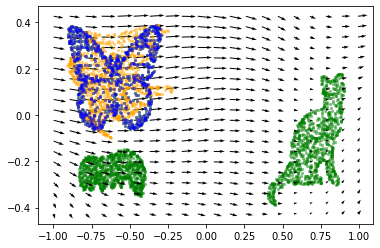

In [13]:
import Utils; importlib.reload(Utils); from Utils import SaveTrajectory as st
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));
model = FfjordModel(sigmac = 3.5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
model.load_state("results/experiment_radial/models/state_final.tar")
cpt = time.time()
st.save_trajectory(model, keyframes, savename='save_debug_1', nsteps=20, dpiv=400, n=1000, alpha=.5, ot_type=1)
print(time.time()-cpt)
cpt = time.time()
st.save_trajectory(model, keyframes, savename='save_debug_2', nsteps=20, dpiv=400, n=1000, alpha=.5, ot_type=2)
print(time.time()-cpt)

In [7]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 3.5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
outfolder = "results/experiment_radial/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False)

  0%|          | 0/300 [00:01<?, ?it/s]


AttributeError: 'velocMLP' object has no attribute 'imap'

In [106]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
outfolder = "results/experiment_kurl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 500, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False)


  0%|          | 0/500 [00:00<?, ?it/s]

--Return--
None
> /mnt/pzpzpzp1/wassflow/Utils.py(46)radialKE()
     44         return 30*nn.Softplus(beta)(-dets);
     45     def radialKE(tz,z_dots):
---> 46         pdb.set_trace()
     47 
     48 



ipdb>  tz.shape


torch.Size([600, 3])


ipdb>  x = tz[:,1]; y = tz[:,2];
ipdb>  torch.stack((y, -x),dim=0).shape


torch.Size([2, 600])


ipdb>  dir = torch.stack((y, -x),dim=0)
ipdb>  normalizedCircular = dir/dir.norm(p=2,dim=1)


*** RuntimeError: The size of tensor a (600) must match the size of tensor b (2) at non-singleton dimension 1


ipdb>  dir.shape


torch.Size([2, 600])


ipdb>  y.shape


torch.Size([600])


ipdb>  dir = torch.stack((y, -x), dim=1)
ipdb>  dir.shape


torch.Size([600, 2])


ipdb>  dir.norm(p=2,dim=1).shape


torch.Size([600])


ipdb>  normalizedCircular = dir/dir.norm(p=2,dim=1)


*** RuntimeError: The size of tensor a (2) must match the size of tensor b (600) at non-singleton dimension 1


ipdb>  dir.shape


torch.Size([600, 2])


ipdb>  torch.norm(dir,p=2,dim=1).shape


torch.Size([600])


ipdb>  dir.norm(p=2,dim=1).shape


torch.Size([600])


ipdb>  dir.shape


torch.Size([600, 2])


ipdb>  torch.norm(dir,p=2,dim=1,keepdim=True).shape


torch.Size([600, 1])


ipdb>  normalizedCircular = dir/dir.norm(p=2,dim=1,keepdim=True)
ipdb>  normalizedCircular.shape


torch.Size([600, 2])


ipdb>  z_dots.shape


torch.Size([600, 2])


ipdb>  normalizedCircular.shape


torch.Size([600, 2])


ipdb>  torch.dot(z_dots,normalizedCircular).shape


*** RuntimeError: 1D tensors expected, but got 2D and 2D tensors


ipdb>  (z_dots*normalizedCircular).shape


torch.Size([600, 2])


ipdb>  (z_dots*normalizedCircular).sum(dim=1).shape


torch.Size([600])


ipdb>  q


  0%|          | 0/500 [08:53<?, ?it/s]


BdbQuit: 

  0%|          | 1/300 [00:00<03:07,  1.59it/s]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 1.4231 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6283 | Iter: 0.6264 | fit: 0.1821 | reg: 0.1153 | save: 0.0000) | autograd: 0.3266]



 17%|█▋        | 51/300 [00:42<11:06,  2.67s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 1.2657 | lr: 0.0001 | n_subsample: 378] 
[Total time : 42.0400 | Iter: 35.0426 | fit: 0.2148 | reg: 0.1468 | save: 6.3662) | autograd: 0.4239]



 34%|███▎      | 101/300 [01:29<09:14,  2.79s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 1.2325 | lr: 0.0001 | n_subsample: 476] 
[Total time : 89.8490 | Iter: 41.2249 | fit: 0.2251 | reg: 0.0792 | save: 6.5818) | autograd: 0.4665]



 50%|█████     | 151/300 [02:16<06:40,  2.69s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 1.1822 | lr: 0.0001 | n_subsample: 600] 
[Total time : 136.2798 | Iter: 40.0430 | fit: 0.2106 | reg: 0.1457 | save: 6.3855) | autograd: 0.4156]



 67%|██████▋   | 201/300 [03:06<04:53,  2.97s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 1.4605 | lr: 0.0001 | n_subsample: 756] 
[Total time : 186.4361 | Iter: 43.4585 | fit: 0.2447 | reg: 0.1359 | save: 6.6955) | autograd: 0.5517]



 84%|████████▎ | 251/300 [03:59<02:18,  2.83s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 1.2821 | lr: 5e-05 | n_subsample: 953] 
[Total time : 239.0517 | Iter: 46.1685 | fit: 0.2483 | reg: 0.1751 | save: 6.4459) | autograd: 0.4845]



100%|██████████| 300/300 [04:48<00:00,  1.04it/s]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 1.2566 | lr: 5e-05 | n_subsample: 953] 
[Total time : 288.6622 | Iter: 42.9576 | fit: 0.2371 | reg: 0.1830 | save: 6.6507) | autograd: 0.4802]




  0%|          | 1/300 [00:00<04:24,  1.13it/s]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 1.4390 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.8876 | Iter: 0.8856 | fit: 0.1766 | reg: 0.1221 | save: 0.0000) | autograd: 0.5844]



 17%|█▋        | 51/300 [00:54<13:00,  3.13s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 0.6083 | lr: 0.0001 | n_subsample: 378] 
[Total time : 54.2091 | Iter: 46.6002 | fit: 0.2118 | reg: 0.1342 | save: 6.7190) | autograd: 0.7483]



 34%|███▎      | 101/300 [02:04<10:59,  3.32s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 0.1924 | lr: 0.0001 | n_subsample: 476] 
[Total time : 124.5992 | Iter: 63.8408 | fit: 0.2486 | reg: 0.1889 | save: 6.5455) | autograd: 1.0136]



 50%|█████     | 151/300 [03:18<08:22,  3.37s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 0.1225 | lr: 0.0001 | n_subsample: 600] 
[Total time : 198.7079 | Iter: 67.4190 | fit: 0.2385 | reg: 0.1110 | save: 6.6875) | autograd: 0.8532]



 67%|██████▋   | 201/300 [04:40<05:59,  3.63s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 0.1422 | lr: 0.0001 | n_subsample: 756] 
[Total time : 280.9411 | Iter: 75.6068 | fit: 0.2844 | reg: 0.2415 | save: 6.6241) | autograd: 1.2553]



 84%|████████▎ | 251/300 [06:13<03:02,  3.73s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 0.0850 | lr: 0.0001 | n_subsample: 953] 
[Total time : 373.0079 | Iter: 85.2157 | fit: 0.2887 | reg: 0.2248 | save: 6.8485) | autograd: 1.2293]



100%|██████████| 300/300 [07:39<00:00,  1.53s/it]

Allocated: 0.03 GB  Reserved: 0.64 GB
[Loss: 0.0852 | lr: 0.0001 | n_subsample: 953] 
[Total time : 459.5279 | Iter: 79.8615 | fit: 0.2799 | reg: 0.2362 | save: 6.6561) | autograd: 1.2123]



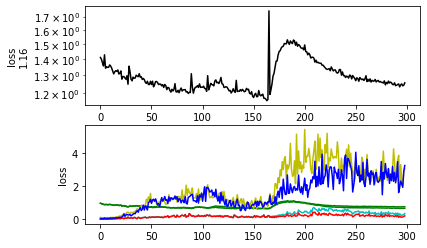

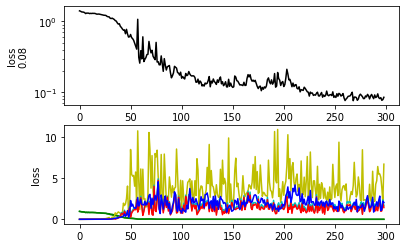

In [90]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False, initzero = False).to(device)
outfolder = "results/experiment_tzm_detach_300/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = True)

model = FfjordModel(sigmac = 5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
outfolder = "results/experiment_tzm_no_detach_300/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False)


  1%|          | 1/150 [00:01<02:53,  1.17s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.1661 | Iter: 1.1645 | fit: 0.1963 | reg: 0.2036 | save: 0.0000) | autograd: 0.7626]



 34%|███▍      | 51/150 [01:25<07:30,  4.55s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0895 | lr: 0.0001 | n_subsample: 378] 
[Total time : 85.7592 | Iter: 75.8583 | fit: 0.3328 | reg: 0.2743 | save: 8.7323) | autograd: 1.4280]



 67%|██████▋   | 101/150 [03:02<03:30,  4.29s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0323 | lr: 0.0001 | n_subsample: 476] 
[Total time : 182.8113 | Iter: 88.2122 | fit: 0.3094 | reg: 0.1389 | save: 8.8375) | autograd: 0.9932]



100%|██████████| 150/150 [04:34<00:00,  1.83s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0293 | lr: 0.0001 | n_subsample: 476] 
[Total time : 274.4461 | Iter: 82.8318 | fit: 0.2965 | reg: 0.1288 | save: 8.8007) | autograd: 1.0328]




  1%|          | 1/150 [00:00<01:49,  1.35it/s]

Allocated: 0.06 GB  Reserved: 0.64 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.7391 | Iter: 0.7374 | fit: 0.1595 | reg: 0.0974 | save: 0.0000) | autograd: 0.4780]



 34%|███▍      | 51/150 [01:02<06:08,  3.72s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.1101 | lr: 0.0001 | n_subsample: 378] 
[Total time : 62.8577 | Iter: 53.6957 | fit: 0.2233 | reg: 0.0691 | save: 8.4203) | autograd: 0.6247]



 67%|██████▋   | 101/150 [02:20<03:21,  4.11s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0385 | lr: 0.0001 | n_subsample: 476] 
[Total time : 140.0952 | Iter: 68.6479 | fit: 0.2709 | reg: 0.2277 | save: 8.5871) | autograd: 1.0704]



100%|██████████| 150/150 [03:48<00:00,  1.52s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0286 | lr: 0.0001 | n_subsample: 476] 
[Total time : 228.5824 | Iter: 79.8733 | fit: 0.2826 | reg: 0.1592 | save: 8.6108) | autograd: 1.0802]



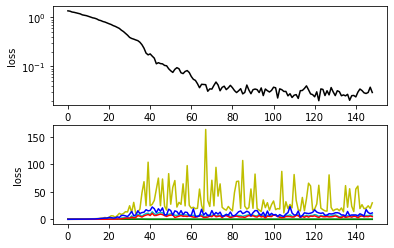

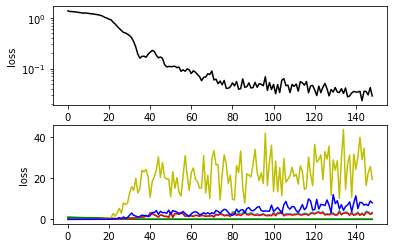

In [26]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False, initzero = False).to(device)
outfolder = "results/experiment_without_incremental_mask/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 150, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
outfolder = "results/experiment_with_incremental_mask/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 150, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)


In [23]:
# establish some baselines. with regularizers and small weight. ~450s for 200 iters.
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
outfolder = "results/experiment_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 200, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)


  0%|          | 1/200 [00:00<03:10,  1.05it/s]

Allocated: 0.03 GB  Reserved: 0.34 GB
[Loss: 1000.0000 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.9565 | Iter: 0.9548 | fit: 0.1575 | reg: 0.0968 | save: 0.0000) | autograd: 0.6982]


  2%|▏         | 4/200 [00:05<04:05,  1.25s/it]


KeyboardInterrupt: 

  0%|          | 1/300 [00:00<04:38,  1.07it/s]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.9307 | Iter: 0.9288 | fit: 0.1636 | reg: 0.1172 | save: 0.0000) | autograd: 0.6464]


 17%|█▋        | 51/300 [01:13<16:47,  4.05s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.1008 | lr: 0.0001 | n_subsample: 378] 
[Total time : 73.1305 | Iter: 63.5976 | fit: 0.2111 | reg: 0.1375 | save: 8.5986) | autograd: 1.0661]


 34%|███▎      | 101/300 [02:44<14:57,  4.51s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.0338 | lr: 0.0001 | n_subsample: 476] 
[Total time : 164.7504 | Iter: 82.8708 | fit: 0.2317 | reg: 0.1761 | save: 8.7456) | autograd: 1.3259]


 50%|█████     | 151/300 [04:53<12:37,  5.08s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.0321 | lr: 0.0001 | n_subsample: 600] 
[Total time : 293.0161 | Iter: 119.3900 | fit: 0.3070 | reg: 0.1675 | save: 8.8723) | autograd: 1.8464]


 67%|██████▋   | 201/300 [06:59<08:07,  4.93s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.0331 | lr: 0.0001 | n_subsample: 756] 
[Total time : 419.7901 | Iter: 118.0282 | fit: 0.2766 | reg: 0.1524 | save: 8.7414) | autograd: 1.8436]


 84%|████████▎ | 251/300 [09:03<03:58,  4.87s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.0206 | lr: 0.0001 | n_subsample: 953] 
[Total time : 543.3498 | Iter: 114.8276 | fit: 0.2734 | reg: 0.1700 | save: 8.7290) | autograd: 1.6347]


100%|██████████| 300/300 [10:53<00:00,  2.18s/it]


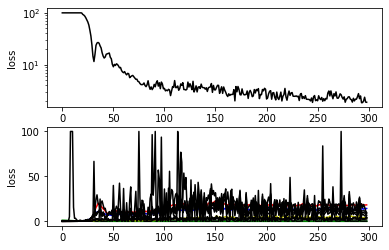

In [72]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
outfolder = "results/experiment_relweight/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)
st.save_losses(losses, separate_losses, outfolder=outfolder, maxcap=100)

In [ ]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));
sigmacs = range(2,8)
models = []
lossess = []
separate_lossess = []
separate_timess = []
for sigmaci in range(len(sigmacs)):
    sigmac = sigmacs[sigmaci]
    model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
    outfolder = "results/experiment3_sigma_" + f"{sigmac:02}/"
    model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 100, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)
    st.save_losses(losses, separate_losses, outfolder=outfolder)
    models.append(model);    lossess.append(losses);    separate_lossess.append(separate_losses);    separate_timess.append(separate_times)

  1%|          | 1/100 [00:00<01:26,  1.14it/s]

Allocated: 0.03 GB  Reserved: 0.38 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.8729 | Iter: 0.8712 | fit: 0.1615 | reg: 0.0960 | save: 0.0000) | autograd: 0.6118]


 19%|█▉        | 19/100 [00:19<01:21,  1.01s/it]


KeyboardInterrupt: 

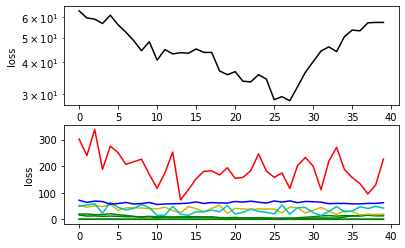

In [16]:
import Utils; importlib.reload(Utils); from Utils import SaveTrajectory as st
st.save_losses(losses, separate_losses, outfolder=outfolder, maxcap=10000, start = 60, end = 500)